In [50]:
# Put all library imports in this block!
import pandas as pd
!pip install numdifftools
import numdifftools as nd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import matplotlib.dates as mdates
import matplotlib.lines as mlines
from scipy.optimize import minimize
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from sklearn.metrics import r2_score

In [51]:
!git clone https://github.com/avril-rdgz/E_EORM_AECTR_GA2.git
%cd E_EORM_AECTR_GA2


Cloning into 'E_EORM_AECTR_GA2'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 122 (delta 7), reused 1 (delta 1), pack-reused 100 (from 1)
Receiving objects: 100% (122/122), 6.02 MiB | 17.07 MiB/s, done.
Resolving deltas: 100% (40/40), done.
/Users/pepijnbouwman/AE_Group_05/E_EORM_AECTR_GA2/E_EORM_AECTR_GA2


In [52]:
# Data prep
data_vintage = pd.read_csv('2025-08-MD.csv')
data_vintage = data_vintage[['sasdate', 'UNRATE', 'INDPRO']]
data_vintage = data_vintage.iloc[1:].copy()

df_log_diff = pd.DataFrame()
df_log_diff['DATE'] = pd.to_datetime(data_vintage['sasdate'])
df_log_diff['UNRATE'] = np.log(data_vintage['UNRATE']).diff()
df_log_diff['INDPRO'] = np.log(data_vintage['INDPRO']).diff()
df_log_diff = df_log_diff.iloc[1:].copy()

display(df_log_diff.head())

,DATE,UNRATE,INDPRO
2,1959-02-01,-0.016807,0.019395
3,1959-03-01,-0.052186,0.014300
4,1959-04-01,-0.074108,0.021080
5,1959-05-01,-0.019418,0.014954
6,1959-06-01,-0.019803,0.001137


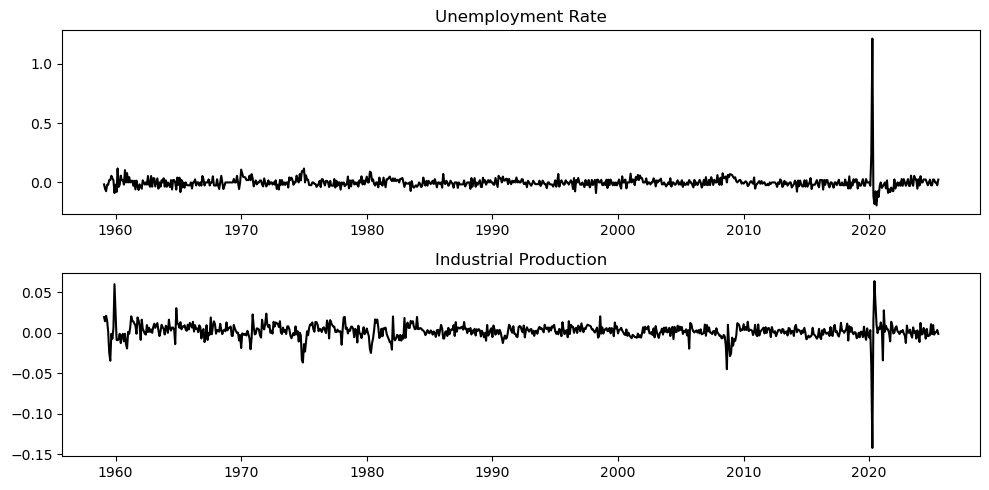

In [53]:
# Plotting log differences
plt.figure(figsize=(10,5))

## Unemployment rate
plt.subplot(2,1,1)
plt.plot(df_log_diff['DATE'], df_log_diff['UNRATE'], color='black')
plt.title('Unemployment Rate')

## Industrial production
plt.subplot(2,1,2)
plt.plot(df_log_diff['DATE'], df_log_diff['INDPRO'], color='black')
plt.title('Industrial Production')

plt.tight_layout()
plt.show()

# Question 2

In [54]:
def get_avg_total_loss(theta, model_name, x, y = None):
     # The loss function is the average sum of squared residuals.
  mu, delta, gamma, alpha, beta = theta
  x = np.asarray(x)
  y = np.asarray(y)

  div = 0

  if model_name == 'SESTAR':
    div = gamma / (1 + np.exp(alpha + beta * x[:-1]))
  elif model_name == 'STAR':
    div = gamma / (1 + np.exp(alpha + beta * y[:-1]))

  resid = x[1:] - mu - (delta + div) * x[:-1]

  return np.mean(resid**2)

In [55]:
# Test point for total loss (OK)
theta_star = (0, 0.3, 1, 0, 2)

for model in model_names:
  total_loss = get_total_loss(theta_star, model, df_log_diff['UNRATE'], df_log_diff['INDPRO'])
  print(f'Total Loss for {model}: {total_loss:.6f}')

Total Loss for AR(1): 2.420311
Total Loss for SESTAR: 2.687785
Total Loss for STAR: 3.652962


In [56]:
# Results for Q2

theta_tilde = (0, 0.1, 2, 0, 3)
results_Q2 = {}

for model in model_names:
  total_loss = get_total_loss(theta_tilde, model, df_log_diff['UNRATE'], df_log_diff['INDPRO'])
  print(f'Total Loss for {model}: {total_loss:.6f}')

  results_Q2[model] = {
      'total_loss': total_loss
  }

Total Loss for AR(1): 2.329560
Total Loss for SESTAR: 2.847958
Total Loss for STAR: 5.435420


# Question 3

In [57]:
def estimate_model(theta_init, model_name, x, y=None):

  result = minimize(get_avg_total_loss,
                    theta_init,
                    args=(model_name, x, y),
                    method='BFGS',
                    options={'maxiter': 100,'gtol':1e-8})


  if model_name not in model_names:
    raise ValueError('Invalid model name specified.')

  if not result.success:
     print(f'\nWarning: Optimization failed for {model_name}.')
     print(f'Message: {result.message}\n')
  else:
     print(f'\nOptimization successful for {model_name}. Total Loss: {result.fun:.6f}\n')

  return result.x, result.fun

def fit_values(theta, model_name, x, y=None):
  mu, delta, gamma, alpha, beta = theta
  x = np.asarray(x)
  if y is not None: y = np.asarray(y)

  div = np.zeros_like(x)
  if model_name == 'SESTAR':
    div[1:] = gamma / (1 + np.exp(alpha + beta * x[:-1]))
  elif model_name == 'STAR':
    div[1:] = gamma / (1 + np.exp(alpha + beta * y[:-1]))

  x_fit = mu + (delta + div[1:]) * x[:-1]
  x_fit = np.insert(x_fit, 0, mu / (1 - delta)) # Add 1st observation as unconditional mean

  return x_fit


Initial average loss: 0.003037

Optimization successful for AR(1). Total Loss: 0.002923

Total loss: 2.329415


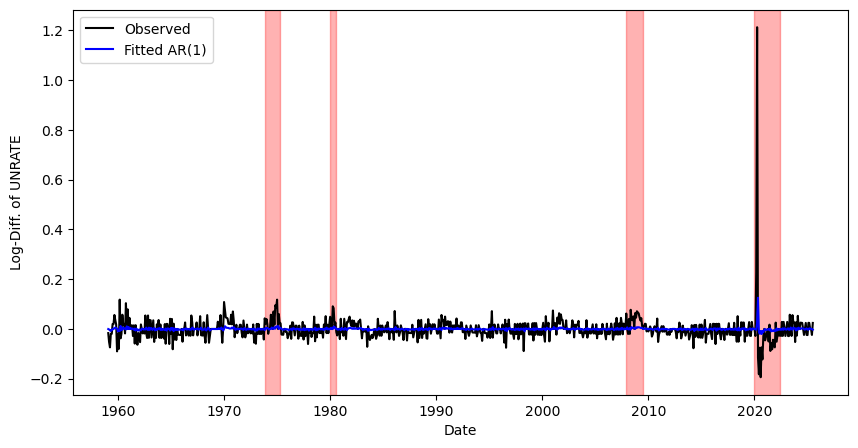

Initial average loss: 0.003037

Message: Maximum number of iterations has been exceeded.

Total loss: 2.222445


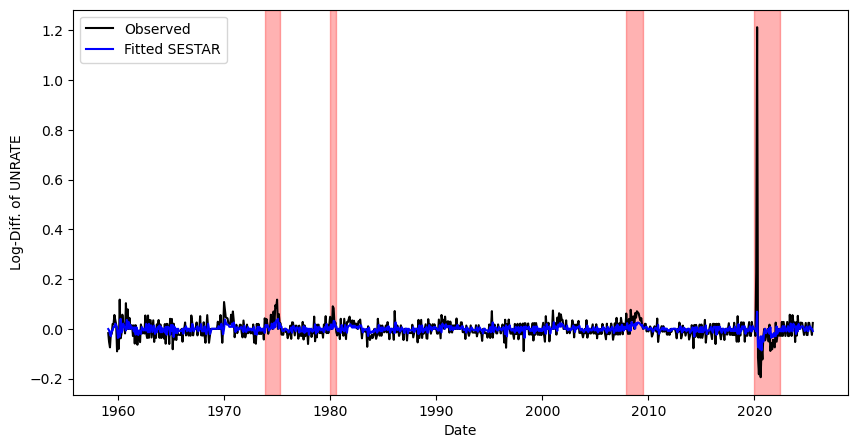

Initial average loss: 0.003037

Message: Maximum number of iterations has been exceeded.

Total loss: 2.247936


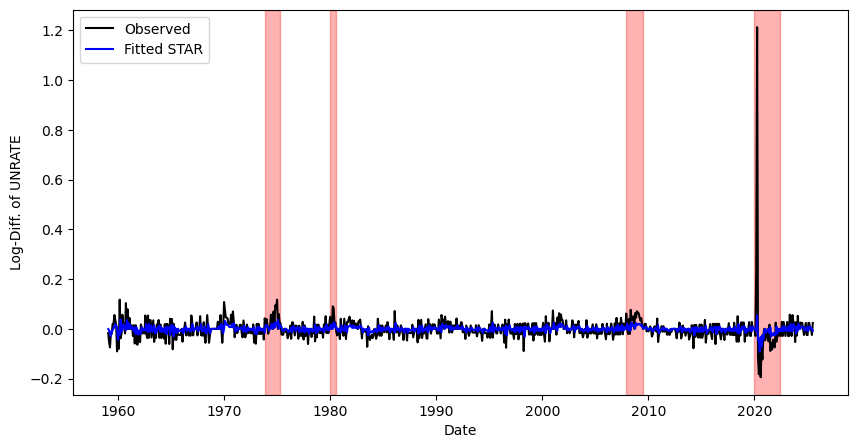

In [58]:
# Results for Q3

theta_init = (0, 0.3, 0, 0, 0)
date = df_log_diff['DATE']
x = df_log_diff['UNRATE']
y = df_log_diff['INDPRO']

recessions_periods = [
    ('1973-11-01', '1975-03-31'),
    ('1980-01-01', '1980-07-31'),
    ('2007-12-01', '2009-06-30'),
    ('2020-01-01', '2022-05-31')
]

results_Q3 = {}

for model in model_names:

  loss_init = get_avg_total_loss(theta_init, model, x, y)
  print(f'Initial average loss: {loss_init:.6f}')

  theta_optim, loss_optim = estimate_model(theta_init, model, x, y)

  total_loss= get_total_loss(theta_optim, model, x, y)
  print(f'Total loss: {total_loss:.6f}')


  results_Q3[model] = {
      'theta': theta_optim,
      'optimize_loss': loss_optim,
      'total_loss':total_loss
  }



  x_fitted = fit_values(theta_optim, model, x, y)

  # Plotting actual vs fitted values
  plt.figure(figsize=(10, 5))
  plt.plot(date, x, label='Observed', color='black')
  plt.plot(date, x_fitted, label=f'Fitted {model}', color='blue')

  for start, end in recessions_periods:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='red', alpha=0.3)

  plt.xlabel('Date')
  plt.ylabel('Log-Diff. of UNRATE')
  plt.legend()

  # Uncomment to store plot
  plt.savefig(f'UNRATE_fitted_{model}.png', bbox_inches='tight', dpi=300)
  plt.show()

  plt.close()

theta_hat_star = np.asarray(results_Q3["STAR"]["theta"])


# Question 4

In [59]:
assert "STAR" in results_Q3
print("θ̂_STAR =", results_Q3["STAR"]["theta"])

θ̂_STAR = [ 6.61305600e-04  3.30960190e+00 -8.43223107e+00  6.10199235e-01
  1.35397355e+00]


In [60]:
assert len(theta_hat_star) == 5
date = pd.to_datetime(df_log_diff["DATE"])

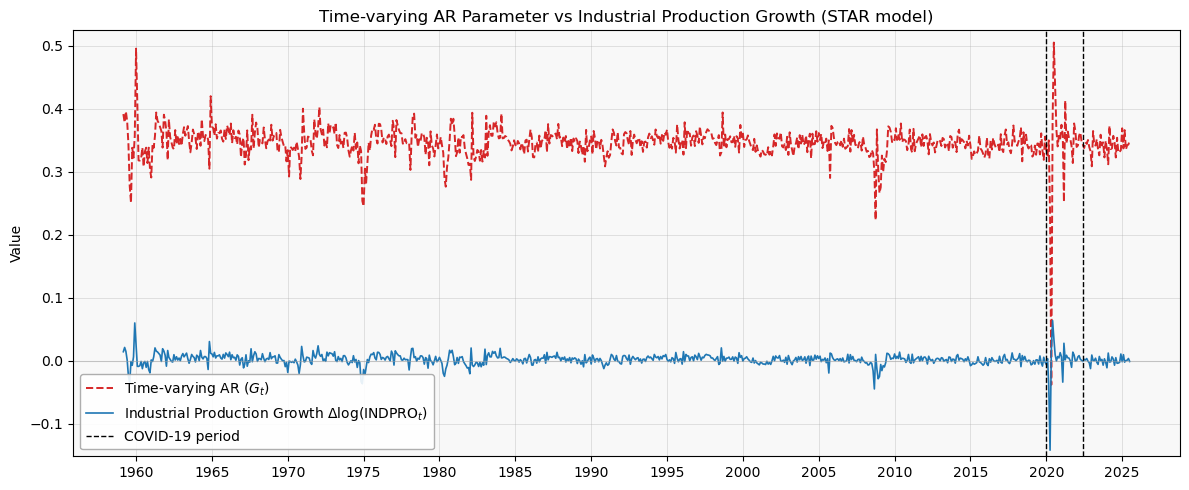

In [61]:
# Results for Q4 (plot G_t and z_t with current θ̂_STAR)

# Parameters and data
mu, delta, gamma, alpha, beta = np.asarray(results_Q3["STAR"]["theta"])
date = pd.to_datetime(df_log_diff["DATE"]).to_numpy()
z    = df_log_diff["INDPRO"].to_numpy()   # Δlog(INDPRO_t)

# Logistic function
def logistic(u):
    u = np.clip(u, -30, 30)
    return 1.0 / (1.0 + np.exp(u))

# G_t (time-varying AR coefficient)
G          = delta + gamma * logistic(alpha + beta * z[:-1])
z_align    = z[1:]
date_align = date[1:]

# Color palette
COL_G      = "#d62728"
COL_Z      = "#1f77b4"
COL_COVID  = "black"   # E64A19 soft orange
COL_GRID   = "#a6a6a6"

# Figure
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_facecolor("#f8f8f8")

# Plot the two lines
ln1, = ax.plot(date_align, G, color=COL_G, lw=1.4, ls="--",
               label=r"Time-varying AR $(G_t)$")
ln2, = ax.plot(date_align, z_align, color=COL_Z, lw=1.2, ls="-",
               label=r"Industrial Production Growth $\Delta\log(\mathrm{INDPRO}_t)$")

# Axis styling
ax.set_ylabel("Value")
ax.axhline(0, lw=0.8, color=COL_GRID, alpha=0.5)
ax.grid(True, which="major", linestyle="-", linewidth=0.6, color=COL_GRID, alpha=0.35)

# Auto-adjust y-limits
ymin = min(z_align.min(), G.min())
ymax = max(z_align.max(), G.max())
pad  = 0.03 * (ymax - ymin if ymax > ymin else 1.0)
ax.set_ylim(ymin - 0.5*pad, ymax + 1.0*pad)

ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# COVID-19
covid_start, covid_end = pd.Timestamp("2020-01-01"), pd.Timestamp("2022-05-31")
ax.axvline(covid_start, color=COL_COVID, ls="--", lw=1)
ax.axvline(covid_end,   color=COL_COVID, ls="--", lw=1)
covid_legend = mlines.Line2D([], [], color=COL_COVID, ls="--", lw=1,
                             label="COVID-19 period")

# Legend and title
ax.legend(handles=[ln1, ln2, covid_legend],
          loc="lower left", framealpha=0.9,
          facecolor="white", edgecolor=COL_GRID)
ax.set_title("Time-varying AR Parameter vs Industrial Production Growth (STAR model)")

plt.tight_layout()
plt.savefig("Q4_STAR_G_vs_INDPRO.png",
            dpi=300,
            bbox_inches="tight",
            facecolor="white",
            pad_inches=0.05)
plt.show()



In [62]:
print("θ̂_STAR =", results_Q3["STAR"]["theta"])
print("Lengths -> G:", len(G), " z_align:", len(z_align), " date_align:", len(date_align))
print("G_t stats -> min:", np.nanmin(G), " max:", np.nanmax(G), " mean:", np.nanmean(G))

# logistic∈(0,1)
lo, hi = (delta + min(0, gamma), delta + max(0, gamma))
print("Theoretical range approx:", (lo, hi))

# sign(dG/dz) = sign(-γβ)
print("sign(dG/dz) =", np.sign(-gamma * beta))


θ̂_STAR = [ 6.61305600e-04  3.30960190e+00 -8.43223107e+00  6.10199235e-01
  1.35397355e+00]
Lengths -> G: 797  z_align: 797  date_align: 797
G_t stats -> min: -0.0382104870799056  max: 0.5052196835913345  mean: 0.3463731826479093
Theoretical range approx: (-5.12262917025684, 3.3096019039643747)
sign(dG/dz) = 1.0


# Question 5

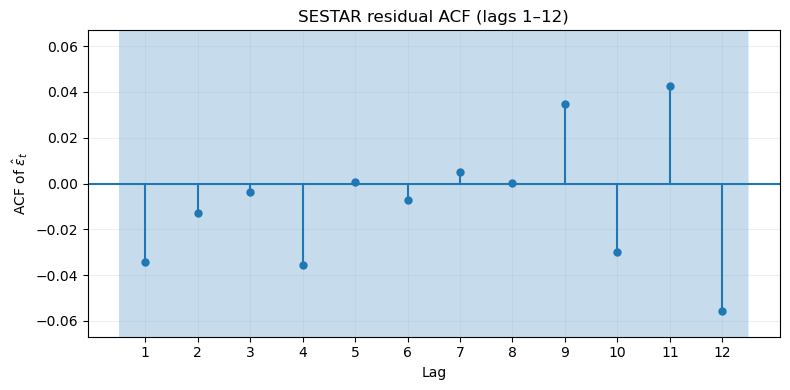

Residual ACF values (lags 1–12):
lag  1: -0.0343
lag  2: -0.0129
lag  3: -0.0039
lag  4: -0.0354
lag  5: +0.0008
lag  6: -0.0072
lag  7: +0.0051
lag  8: +0.0001
lag  9: +0.0349
lag 10: -0.0299
lag 11: +0.0426
lag 12: -0.0557
     lb_stat  lb_pvalue
12  7.853107   0.796502

Residual ACF (lags 1..12):
lag  1: -0.034
lag  2: -0.013
lag  3: -0.004
lag  4: -0.035
lag  5: +0.001
lag  6: -0.007
lag  7: +0.005
lag  8: +0.000
lag  9: +0.035
lag 10: -0.030
lag 11: +0.043
lag 12: -0.056

Approx. 95% reference band: ±0.069  (T=797)


In [63]:
# Results for Q5 (SESTAR residuals, ACF (lags 1–12), and Ljung–Box test)

# 1) Parameters and series
theta_sestar = np.asarray(results_Q3["SESTAR"]["theta"])
mu, delta, gamma, alpha, beta = theta_sestar
date = pd.to_datetime(df_log_diff["DATE"])
x = df_log_diff["UNRATE"].to_numpy()

# 2) Fitted values and residuals for SESTAR
def logistic(u):
    u = np.clip(u, -30, 30)
    return 1.0 / (1.0 + np.exp(u))

g = gamma * logistic(alpha + beta * x[:-1])
x_hat = mu + (delta + g) * x[:-1]

eps = np.empty_like(x, dtype=float)
eps[:] = np.nan
eps[1:] = x[1:] - x_hat                       # residuals aligned to t>=2

# 3) Sample ACF up to lag 12
eps_valid = eps[1:] - np.nanmean(eps[1:])     # demean, drop first NaN
T = len(eps_valid)

def sample_acf(series, max_lag):
    denom = np.sum(series**2)
    acfs = []
    for h in range(1, max_lag+1):
        num = np.sum(series[h:] * series[:-h])
        acfs.append(num / denom)
    return np.array(acfs)

max_lag = 12
rho = sample_acf(eps_valid, max_lag=max_lag)
ci = 1.96 / np.sqrt(T)  # ~95% reference band for white noise

# 4) Plot ACF bars (single, main figure)
max_lag = 12
acf_vals = acf(eps_valid, nlags=max_lag, fft=False)[1:]  # drop lag 0
lags = np.arange(1, max_lag + 1)

fig, ax = plt.subplots(figsize=(8, 4))
plot_acf(eps_valid, lags=max_lag, ax=ax, fft=False, zero=False)
ylim = 1.2 * np.nanmax(np.abs(acf_vals))
ax.set_xticks(lags)
ax.set_xticklabels([str(lag) for lag in lags])
ax.set_ylim(-min(1, ylim), min(1, ylim))
ax.set_xlabel("Lag")
ax.set_ylabel(r"ACF of $\hat{\varepsilon}_t$")
ax.set_title("SESTAR residual ACF (lags 1–12)")
ax.grid(alpha=0.2)
plt.tight_layout()
plt.savefig(f'Q5_ACF_SESTAR.png', bbox_inches='tight', dpi=300)
plt.show()


print("Residual ACF values (lags 1–12):")
for h, r in zip(lags, acf_vals):
    print(f"lag {h:2d}: {r:+.4f}")

# 5) Ljung–Box test up to lag 12
if acorr_ljungbox is not None:
    lb = acorr_ljungbox(eps_valid, lags=[12], return_df=True)  # columns: lb_stat, lb_pvalue
    print(lb)
else:
    print("statsmodels not available -> skipped Ljung–Box test.")

# 6) Print ACF values and CI
print("\nResidual ACF (lags 1..12):")
for h, r in zip(lags, rho):
    print(f"lag {h:2d}: {r:+.3f}")
print(f"\nApprox. 95% reference band: ±{ci:.3f}  (T={T})")

plt.show()


# Question 6

In [64]:
# Check the data structure from question 3
print(results_Q3)
print(results_Q3.keys())

{'AR(1)': {'theta': array([-0.00037695,  0.10358028,  0.        ,  0.        ,  0.        ]), 'optimize_loss': 0.0029227290528539623, 'total_loss': 2.329415055124608}, 'SESTAR': {'theta': array([ 8.24925618e-04,  3.37813835e+00, -8.69115263e+00,  6.41377519e-01,
       -1.79638726e-01]), 'optimize_loss': 0.002788513494494475, 'total_loss': 2.222445255112097}, 'STAR': {'theta': array([ 6.61305600e-04,  3.30960190e+00, -8.43223107e+00,  6.10199235e-01,
        1.35397355e+00]), 'optimize_loss': 0.0028204971426125493, 'total_loss': 2.2479362226622017}}
dict_keys(['AR(1)', 'SESTAR', 'STAR'])


In [65]:
# Robust std errors
x = df_log_diff['UNRATE'].to_numpy()
y = df_log_diff['INDPRO'].to_numpy()

# q function for non-linear least squares
def q_t(theta, model, x, y=None):
    mu, delta, gamma, alpha, beta = theta
    fitted = fit_values(theta, model, x, y)
    resid = x[1:] - fitted[1:]
    return resid**2

# Newey–West estimator
def nw(grad, p=12):
    T= grad.shape[0]
    Sigma0 = grad.T @ grad / T #lag 0
    Sigma = Sigma0.copy()
    for j in range(1, p+1):
        coef = 1 - j/(p+1)
        Sigmaj = (grad[j:].T @ grad[:-j]) / T #lag j
        Sigma += coef * (Sigmaj + Sigmaj.T)
    return Sigma

def grad(theta, model, x, y=None):
    q_fun = lambda param: q_t(param, model, x, y)
    return nd.Jacobian(q_fun)(theta)

def hessian_mean(theta, model, x, y=None):
    q_mean = lambda param: q_t(param, model, x, y).mean()
    return nd.Hessian(q_mean)(theta)   # (k × k)

# Results for all the models
robust_se = []

for model in results_Q3.keys():
    theta_hat = results_Q3[model]['theta']
    q = q_t(theta_hat, model, x, y)
    g = grad(theta_hat, model, x, y)
    H = hessian_mean(theta_hat, model, x, y)
    if model == 'AR(1)':
        g = g[:, :2]
        H = H[:2, :2]
    sigular = 1e-8
#     Omega = np.linalg.inv(H + sigular * np.eye(H.shape[0]))
    Omega = np.linalg.inv(H)
    Sigma = nw(g)
    var = Omega @ Sigma @ Omega.T
    se = np.sqrt(np.diag(var))
    robust_se.append((model, theta_hat, se, results_Q3[model]['total_loss']))

print(robust_se)

[('AR(1)', array([-0.00037695,  0.10358028,  0.        ,  0.        ,  0.        ]), array([0.05423912, 1.38127691]), 2.329415055124608), ('SESTAR', array([ 8.24925618e-04,  3.37813835e+00, -8.69115263e+00,  6.41377519e-01,
       -1.79638726e-01]), array([6.76222000e-02, 4.71233058e+01, 9.18809892e+01, 3.96901486e+00,
       1.10687278e+00]), 2.222445255112097), ('STAR', array([ 6.61305600e-04,  3.30960190e+00, -8.43223107e+00,  6.10199235e-01,
        1.35397355e+00]), array([6.57272524e-02, 4.35910620e+01, 8.54064117e+01, 3.47388616e+00,
       1.04088728e+01]), 2.2479362226622017)]


In [66]:
# R squared
def r2_stats(model, theta):
    x_fit = fit_values(theta, model, x, y)
    R2 = r2_score(x, x_fit)
    T = len(x)
    k = 2 if model == 'AR(1)' else 5
    R2_adj = 1 - (1 - R2) * (T - 1) / (T - k - 1)
    return R2, R2_adj

In [67]:
# Latex

robust_dict = {m: {"theta": th, "se": se, "loss": loss} for (m, th, se, loss) in robust_se}

def pad_params(model, theta, se):
    if model == 'AR(1)':
        theta = np.array([theta[0], theta[1], np.nan, np.nan, np.nan], dtype=float)
        se    = np.array([se[0],    se[1],    np.nan, np.nan, np.nan], dtype=float)
    return theta, se

def fnum(v, digs=2):
    return "" if v is None or np.isnan(v) else f"{v:.{digs}f}"

def fse(v, digs=2):
    return "" if v is None or np.isnan(v) else f"({v:.{digs}f})"

col_titles   = ['AR', 'SESTAR', 'STAR']
param_labels = [r'$\mu$', r'$\delta$', r'$\gamma$', r'$\alpha$', r'$\beta$']

table_data = {}
for m in results_Q3.keys():
    th, se = robust_dict[m]["theta"], robust_dict[m]["se"]
    th, se = pad_params(m, th, se)
    R2, R2_adj = r2_stats(m, th)
    table_data[m] = {
        "theta": th,
        "se": se,
        "loss": robust_dict[m]["loss"],
        "R2": R2,
        "R2_adj": R2_adj
    }


lines = []
lines.append(r"\begin{table}[htbp]")
lines.append(r"\centering")
lines.append(r"\caption{Estimated parameters with the robust standard errors}")
lines.append(r"\begin{tabular}{lccc}")
lines.append(r"\toprule")
lines.append(r" & " + " & ".join(col_titles) + r" \\")
lines.append(r"\midrule")

for j, lab in enumerate(param_labels):
    est_row = [lab]
    se_row  = [""]
    for m in results_Q3.keys():
        est_row.append(fnum(table_data[m]["theta"][j], 2))
        se_row.append(fse(table_data[m]["se"][j], 2))
    lines.append(" & ".join(est_row) + r" \\")
    lines.append(" & ".join(se_row)  + r" \\")

lines.append(r"\addlinespace")
stat_labels = [r"\emph{Loss}", r"$R^2$", r"$R^2_{\text{adj}}$"]
for stat in stat_labels:
    row = [stat]
    for m in results_Q3.keys():
        if stat == r"\emph{Loss}":
            row.append(fnum(table_data[m]["loss"], 2))
        elif stat == r"$R^2$":
            row.append(fnum(table_data[m]["R2"], 2))
        else:
            row.append(fnum(table_data[m]["R2_adj"], 2))
    lines.append(" & ".join(row) + r" \\")
lines.append(r"\bottomrule")
lines.append(r"\end{tabular}")
lines.append(r"\end{table}")

tex_str = "\n".join(lines)
print(tex_str)

with open("table1.tex", "w", encoding="utf-8") as f:
    f.write(tex_str)

\begin{table}[htbp]
\centering
\caption{Estimated parameters with the robust standard errors}
\begin{tabular}{lccc}
\toprule
 & AR & SESTAR & STAR \\
\midrule
$\mu$ & -0.00 & 0.00 & 0.00 \\
 & (0.05) & (0.07) & (0.07) \\
$\delta$ & 0.10 & 3.38 & 3.31 \\
 & (1.38) & (47.12) & (43.59) \\
$\gamma$ &  & -8.69 & -8.43 \\
 &  & (91.88) & (85.41) \\
$\alpha$ &  & 0.64 & 0.61 \\
 &  & (3.97) & (3.47) \\
$\beta$ &  & -0.18 & 1.35 \\
 &  & (1.11) & (10.41) \\
\addlinespace
\emph{Loss} & 2.33 & 2.22 & 2.25 \\
$R^2$ & 0.01 & 0.06 & 0.05 \\
$R^2_{\text{adj}}$ & 0.01 & 0.05 & 0.04 \\
\bottomrule
\end{tabular}
\end{table}


# Question 7


In [68]:
GAMMA_IDX = 2  # (mu, delta, gamma, alpha, beta)

def two_sided_p_from_t(t):
    # Normal approx p-value using erf
    return 2.0 * (1.0 - 0.5 * (1.0 + math.erf(abs(t) / math.sqrt(2.0))))

rows = []
for model in ["SESTAR", "STAR"]:
    theta = table_data[model]["theta"]
    sevec = table_data[model]["se"]
    g_est = float(theta[GAMMA_IDX])
    g_se  = float(sevec[GAMMA_IDX])
    tval  = g_est / g_se
    pval  = two_sided_p_from_t(tval)
    rows.append({
        "Model": model,
        "Parameter": "gamma",
        "Estimate": g_est,
        "SE (robust)": g_se,
        "t-stat": tval,
        "p-value": pval
    })

Q7_wald = pd.DataFrame(rows)


print("Q7 — Wald test (two-sided) for non-linear time-dependence (γ = 0)\n")
print(f"{'Model':<8} {'Param':<6} {'Est':>12} {'SE':>12} {'t':>10} {'p':>10}")
for _, r in Q7_wald.iterrows():
    est = fnum(r['Estimate'], 2)
    se  = fse(r['SE (robust)'], 2)
    t   = fnum(r['t-stat'], 3)
    p   = "<1e-16" if (isinstance(r['p-value'], float) and r['p-value'] < 1e-16) else f"{r['p-value']:.3g}"
    print(f"{r['Model']:<8} {r['Parameter']:<6} {est:>12} {se:>12} {t:>10} {p:>10}")



Q7 — Wald test (two-sided) for non-linear time-dependence (γ = 0)

Model    Param           Est           SE          t          p
SESTAR   gamma         -8.69      (91.88)     -0.095      0.925
STAR     gamma         -8.43      (85.41)     -0.099      0.921
